In [1]:
%load_ext autoreload

In [2]:
%autoreload
from npyx import *
try:
    import cupy as cp
except ImportError:
    print("cupy could not be imported")


npyx version 2.6.1 imported.


# Load cluster info to estimate depth

In [3]:
# load metadata
#dp = '/mnt/d/spikes/CA011/2022-10-13_12-51-32/Record Node 107/experiment1/recording1'
#start_time = 168801936
dp = '/mnt/d/spikes/CA011/2022-10-14_12-28-53/Record Node 107/experiment1/recording1'
start_time = 58544784
meta = read_metadata(dp)

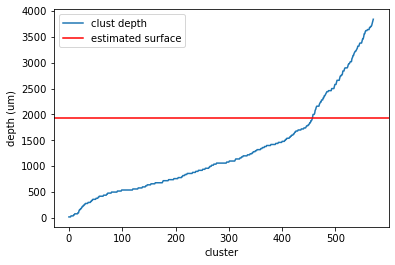

In [4]:
# test_npyx(dp)
clust = get_units(dp)
clust_info = get_units_info(dp)

# approximate brain surface by looking at where the units are
surface_depth = np.sort(clust_info.depth)[np.argwhere(np.diff(np.sort(clust_info.depth))>50)[0][0]]
plt.plot(np.sort(clust_info.depth),label='clust depth')
plt.axhline(surface_depth,color='r',label='estimated surface')
plt.xlabel('cluster')
plt.ylabel('depth (um)')
plt.legend()

# adjust depth to be relative to brain surface
clust_info['adj_depth'] = -(clust_info.depth - surface_depth)

In [5]:
# load the messages
fs = meta['highpass']['sampling_rate']
ts = np.load(f'{dp}/events/MessageCenter/sample_numbers.npy') - start_time # offset by recording start time
txt = np.load(f'{dp}/events/MessageCenter/text.npy')
txt = [t.decode('UTF-8') for t in txt]
u,i = np.unique(ts,return_index=True)
ts = ts[i] / fs / 60 # convert to minutes
txt = [txt[j] for j in i]

# Synchronize data streams
First load timestamps for relevant files

In [6]:
if (2+2) == 5:
    ts = {'ap': np.load(os.path.join(dp,'continuous','Neuropix-PXI-100.ProbeA-AP','timestamps.npy')),\
          'lfp': np.load(os.path.join(dp,'continuous','Neuropix-PXI-100.ProbeA-LFP','timestamps.npy')),\
          'nidaq': np.load(os.path.join(dp,'continuous','NI-DAQmx-103.PXI-6133','timestamps.npy'))}

Load raw binary data

In [7]:
def load_binary_chunk(dp, times, channels=np.arange(384), filt_key='lowpass', scale=True, verbose=False):
    dp = Path(dp)
    meta = read_metadata(dp)
    fname = Path(dp)/meta['lowpass']['binary_relative_path'][2:]
    
    fs = meta[filt_key]['sampling_rate']
    Nchans=meta[filt_key]['n_channels_binaryfile']
    bytes_per_sample=2
    
    assert len(times)==2
    assert times[0]>=0
    assert times[1]<meta['recording_length_seconds']
    
    # Format inputs
    ignore_ks_chanfilt = True
    channels=assert_chan_in_dataset(dp, channels, ignore_ks_chanfilt)
    t1, t2 = int(np.round(times[0]*fs)), int(np.round(times[1]*fs))
    
    vmem=dict(psutil.virtual_memory()._asdict())
    chunkSize = int(fs*Nchans*bytes_per_sample*(times[1]-times[0]))
    if verbose:
        print('Used RAM: {0:.1f}% ({1:.2f}GB total).'.format(vmem['used']*100/vmem['total'], vmem['total']/1024/1024/1024))
        print('Chunk size:{0:.3f}MB. Available RAM: {1:.3f}MB.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
    if chunkSize>0.9*vmem['available']:
        print('WARNING you are trying to load {0:.3f}MB into RAM but have only {1:.3f}MB available.\
              Pick less channels or a smaller time chunk.'.format(chunkSize/1024/1024, vmem['available']/1024/1024))
        return
    
    # Get chunk from binary file
    with open(fname, 'rb') as f_src:
        # each sample for each channel is encoded on 16 bits = 2 bytes: samples*Nchannels*2.
        byte1 = int(t1*Nchans*bytes_per_sample)
        byte2 = int(t2*Nchans*bytes_per_sample)
        bytesRange = byte2-byte1

        f_src.seek(byte1)

        bData = f_src.read(bytesRange)
        
    # Decode binary data
    # channels on axis 0, time on axis 1
    assert len(bData)%2==0
    rc = np.frombuffer(bData, dtype=np.int16) # 16bits decoding
    rc = rc.reshape((int(t2-t1), Nchans)).T
    rc = rc[:-1,:] # remove sync channel
    
    # Scale data
    if scale:
        rc = rc * meta['bit_uV_conv_factor'] # convert into uV
    
    return rc

def plot_lfp(arr,times=[],offset=100,ax=plt,**kwargs):
    if not times:
        rng = range(0,arr.shape[1])
    else:
        rng = range(int(np.round(times[0])),
                int(np.round(times[1])))
    plt_dat = arr[:,rng]
    plt_offsets = np.arange(0, plt_dat.shape[0]*offset, offset)
    plt_dat+=plt_offsets[:,np.newaxis]
    
    _ = ax.plot(plt_dat.T,'k',alpha=0.5,linewidth=0.5,**kwargs)

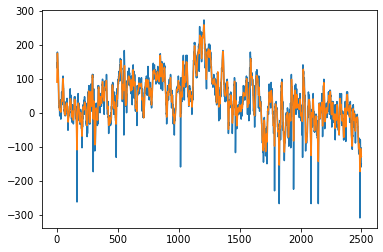

In [19]:
# load and plot baseline period
meta = read_metadata(dp)
fs = meta['lowpass']['sampling_rate']
load_times = [4*60,(4+1)*60]
dat = load_binary_chunk(dp,load_times,filt_key='lowpass')
dat = dat - np.median(dat,axis=1)[:,np.newaxis]
plt.plot(dat[100,0:fs])

# add data to GPU array and filter
d_t = np.ascontiguousarray(dat.T)
d_t = cp.asarray(d_t)
d_filt = gpufilter(d_t, fs=fs, fslow=250, fshigh=0, order=3,
             car=False, forward=True, backward=True, ret_numpy=True).T
plt.plot(d_filt[100,0:fs])

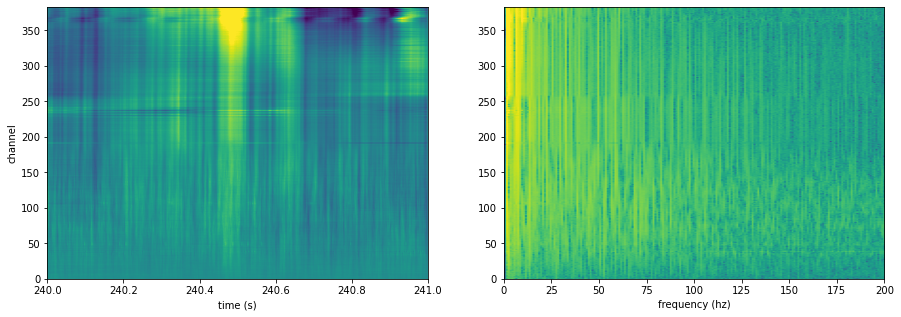

In [37]:
# load and plot baseline period
fs = meta['lowpass']['sampling_rate']
load_times = [4*60,(4*60)+1]
dat = load_binary_chunk(dp,load_times,filt_key='lowpass')
dat = dat - np.median(dat,axis=1)[:,np.newaxis]
d_t = np.ascontiguousarray(dat.T)
d_t = cp.asarray(d_t)
dat = gpufilter(d_t, fs=2500, fslow=300, order=3,
             car=False, forward=True, backward=True, ret_numpy=True).T

fig,ax = plt.subplots(1,2,figsize=(15,5))
#plot_lfp(dat,ax=ax)
ax[0].imshow(dat,aspect='auto',origin='lower',vmin=-500, vmax=500, extent=[load_times[0],load_times[1],0,dat.shape[0]])
ax[0].set_ylabel('channel')
ax[0].set_xlabel('time (s)')

spec = []
for i in range(dat.shape[0]):
    p = 20*np.log10(np.fft.rfft(dat[i,:]))
    spec.append(p)
f = np.linspace(0, fs/2, len(p))
spec = np.real(np.vstack(spec))
flim = 200
ax[1].imshow(spec[:,0:flim],aspect='auto',origin='lower', extent=[0,flim,0,dat.shape[0]],vmin=0, vmax=100)
ax[1].set_xlabel('frequency (hz)')

del dat
fig.savefig('lfp_baseline_im.png')

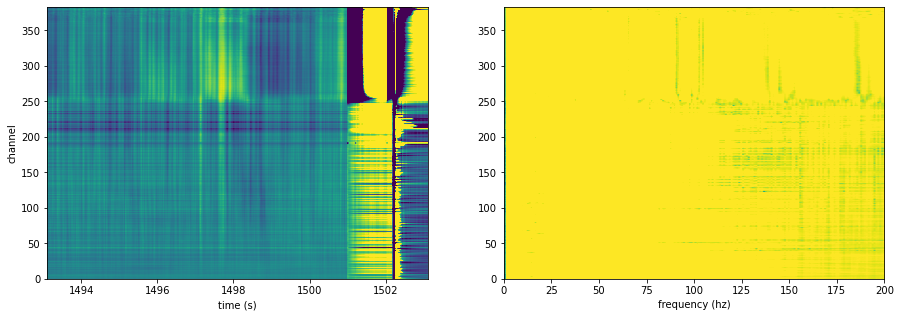

In [43]:
# load and plot robot period
fs = meta['lowpass']['sampling_rate']
load_times = [ts[5]*60+1,ts[5]*60+10+1]
# load_times = [240,241]
dat = load_binary_chunk(dp,load_times,filt_key='lowpass')
dat = dat - np.median(dat,axis=1)[:,np.newaxis]
d_t = np.ascontiguousarray(dat.T)
d_t = cp.asarray(d_t)
dat = gpufilter(d_t, fs=2500, fslow=300, order=3,
             car=False, forward=True, backward=True, ret_numpy=True).T

fig,ax = plt.subplots(1,2,figsize=(15,5))
#plot_lfp(dat,ax=ax)
ax[0].imshow(dat,aspect='auto',origin='lower',vmin=-500, vmax=500, extent=[load_times[0],load_times[1],0,dat.shape[0]])
ax[0].set_ylabel('channel')
ax[0].set_xlabel('time (s)')

spec = []
for i in range(dat.shape[0]):
    p = 20*np.log10(np.fft.rfft(dat[i,:]))
    spec.append(p)
f = np.linspace(0, fs/2, len(p))
spec = np.real(np.vstack(spec))
flim = 200
ax[1].imshow(spec[:,0:flim],aspect='auto',origin='lower', extent=[0,flim,0,dat.shape[0]],vmin=0, vmax=100)
ax[1].set_xlabel('frequency (hz)')

del dat
fig.savefig('lfp_magnet_im.png')

In [40]:
txt

['15 min baseline - left hemi 3000um depth ',
 'magnet testing (~30s, approx 2-3 cm)',
 'move door electronics box into faraday cage',
 'move solenoid near head',
 'solenoid 30 cycles 1hz',
 'poke mouse with lick port cable',
 'door 1 (past minute or so)',
 'door 2']

In [237]:
# load second long chunks of data and compute rms
chunk = 5
nchunks = int(np.ceil(meta['recording_length_seconds'] / chunk))
rms = []
t = []
for i in range(nchunks):
    if (not i % 50) & (i > 0):
        print(f'{i}/{nchunks}, {rms[i-1][0]}')
    times = [i*chunk,np.min([(i+1)*chunk-(1/fs),meta['recording_length_seconds']-(1/fs)])]
    dat = load_binary_chunk(dp,times,filt_key='lowpass')
    
    # compute rms
    rms.append(np.sqrt(np.nanmean((dat - np.median(dat,axis=1)[:,np.newaxis])**2,axis=1)))
    t.append(np.mean(times))

50/368, 15.441116443916144
100/368, 15.747371929613607
150/368, 31.59754321412112
200/368, 12.497548480019434
250/368, 16.40418066378751
300/368, 13.570381915066177
350/368, 21.307410399860228


/mnt/d/spikes/CA011/2022-10-14_12-28-53/Record Node 107/experiment1/recording1
0) 15 min baseline - left hemi 3000um depth 
1) magnet testing (~30s, approx 2-3 cm)
2) move door electronics box into faraday cage
3) move solenoid near head
4) solenoid 30 cycles 1hz
5) poke mouse with lick port cable
6) door 1 (past minute or so)
7) door 2


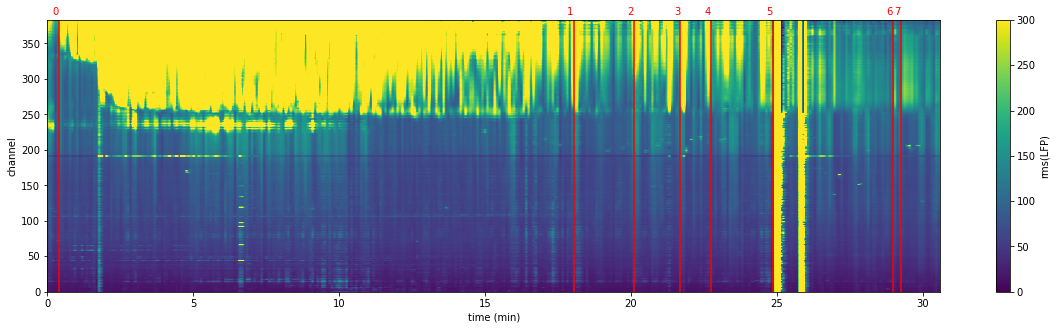

In [238]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

h = ax.imshow(np.vstack(rms).T,aspect='auto',origin='lower',extent=[0,np.max(t)/60,0,dat.shape[0]],vmin=0, vmax=300)
plt.colorbar(h).set_label(label='rms(LFP)')
ax.set_xlabel('time (min)')
ax.set_ylabel('channel')
print(dp)
for i,tt in enumerate(ts):
    ax.axvline(tt,color='r')
    ax.text(tt,390,str(i),color='r',ha='right')
    print(f'{i}) {txt[i]}')